In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
filepath = r"P:\P310002-Geologic Mapping\Titusville30x60\x_sec_data.xlsx"
df_elev = pd.read_excel(filepath)

df_elev.head()

,OBJECTID *,Shape *,ORIG_LEN,ORIG_SEQ,XSec,LiDAR_Elev,Distance_Ft
0,1,Point,0.000000,1,B-B',28.67214,0
1,2,Point,0.001565,2,B-B',28.32927,500
2,3,Point,0.003129,3,B-B',25.84028,1000
3,4,Point,0.004694,4,B-B',26.83729,1500
4,5,Point,0.006259,5,B-B',26.71501,2000


In [3]:
elev = df_elev['LiDAR_Elev'].tolist()
distance = df_elev["Distance_Ft"].tolist()

elev_array = np.array([elev, distance])

In [4]:
well_array = np.array([[16011, 3475, 14710],
                      [1, 0, 1]])

formations = ['TQSU', 'HTRN', 'OCAL', 'AVPK']

elevations = np.array([28.6, 5.1, 10.9])
TQSU = [24, 63, 0]
HTRN = [np.nan, np.nan, 85]
ARCA = [np.nan, np.nan, np.nan]
OCAL = [92, 89, 105]
AVPK = [np.nan, np.nan, 230]
btm =  [99, 126, 300]
distance = np.array([0, 11633, 21870])
og_distance = distance

og_formation_array = np.array([TQSU, HTRN, OCAL, AVPK, btm])


og_formation_array = elevations - og_formation_array 
line_array = og_formation_array

In [8]:
def slope_point_calc(distance1, distance2, depth1, depth2):
    """
    This function finds the elevation and distance of a point on the line between two points
    It is used so that the newly calculated values can be used in plotting dashed lines midway between cuttings and core
    """
    
    slope = (depth2-depth1)/(distance2-distance1)
    midpoint = (distance1 + distance2)/2
    yintercept = depth2 - (slope * distance2)
    new_y = (slope * midpoint) + yintercept

    return new_y, midpoint
    

def side_stack(line_array, new_elev, new_index):
    """
    This function takes the outputs from previous functions and creates a new array with the correct data and format
    to plot dashed and solid lines.
    
    Parameters:
    - line_array: 2D array containing line data.
    - new_elev: 1D array or column vector to insert.
    - new_index: Integer index to indicate where to insert `new_elev`.
    
    Returns:
    - new_array: 2D array with `new_elev` inserted at `new_index` column position.
    """
    
    # Reshape new_elev to ensure it's a column vector
    new_elev = np.array(new_elev).reshape(-1, 1)

    
    if new_index == 1:
        # Grab only the first column for the first half
        first_half = line_array[:, :1]
        second_half = line_array[:, 1:]
        
    elif new_index == (line_array.shape[1] - 1):
        # Grab all except the last column for the first half
        first_half = line_array[:, :-1]
        second_half = line_array[:, -1:]
        
    else:
        # Split at new_index for general cases
        first_half = line_array[:, :new_index]
        second_half = line_array[:, new_index:]

    # Concatenate the arrays along columns
    new_array = np.hstack((first_half, new_elev, second_half))
    return new_array




def add_distance(distance_list, new_distance):
    """
    This locates where the new elevations need to be placed to keep the correct elevation sequence in the formation array.
    It also adds the new distance midpoint and return a sorted array so that the new distance point is in the correct location.
    """
    
    new_index = np.searchsorted(distance_list, new_distance)
    new_distance = np.array([new_distance])
    new_distance_list = np.concatenate((distance_list, new_distance))
    sorted_distance_list = np.sort(new_distance_list)

    return sorted_distance_list, new_index




def midpoints_add(formation_array, distance_array):
    """
    This runs the previous functions to calculate midpoint elevations and add them to a new array for the formations.
    This is needed for the plotting of dashed lines halfway between wells and the pinching out of formations.
    """

    new_formation_array = formation_array
    new_distance_array = distance_array
    
    for i in range(distance_array.shape[0]-1):
        #Calculate the new elevations and new distance point
        new_elev, new_distance = slope_point_calc(distance_array[i], distance_array[i+1], formation_array[:,i], formation_array[:,i+1])
        #Find where to insert the new elevations and add the new distance to the correct spot
        new_distance_array, new_index = add_distance(new_distance_array, new_distance)
        #Add the new elevations to the formation array
        new_formation_array = side_stack(new_formation_array, new_elev, new_index)

    return new_formation_array, new_distance_array
        


def pinch_out(formation_array):
    """
    This calculates the shape of formations that pinch out by assigning the midpoint between wells to the elevation of the below formation
    """
    new_formation_array = formation_array
    for i in range(formation_array.shape[0]):
        for j in range(formation_array.shape[1]-1):
            if np.isnan(formation_array[i, j]) and not np.isnan(formation_array[i, j + 1]):
                #Calculate the point between the above and below points
                k = 1
                while np.isnan(formation_array[i+k, j]):
                    k += 1
                new_formation_array[i, j] = formation_array[i+k, j]
                
            elif not np.isnan(formation_array[i, j]) and np.isnan(formation_array[i, j + 1]): 
                 #Calculate the point between the above and below points
                k = 1
                while np.isnan(formation_array[i+k, j+1]):
                    k += 1
                new_formation_array[i, j+1] = formation_array[i+k, j+1]

    return new_formation_array


def formation_top_bot(formation_array):
    """
    Creates a list of formation polygons that contain a top of formation and bottom of formation. 
    This list of polygons can then be passed to the plotting function to plot them
    """
    
    formation_polygon_list = []

    for i in range(formation_array.shape[0]-1):
        top_of_formation = formation_array[i,:]
        bottom_of_formation = []
        
        for j in range(formation_array.shape[1]):
            if np.isnan(formation_array[i, j]):
                bottom_of_formation.append(np.nan)
                continue
                
            k = 1
            while np.isnan(formation_array[i+k, j]):
                    k += 1
            bottom_of_formation.append(formation_array[i+k, j])

        bottom_of_formation = np.array(bottom_of_formation)
        formation_polygon = np.vstack((top_of_formation, bottom_of_formation))
        formation_polygon_list.append(formation_polygon)

    return formation_polygon_list




def plot_formations(ax, formation_polygons, formation_colors):
    """
    Plots formations with their appropriate formation colors
    """
    
    for formation, color in zip(formation_polygons, formation_colors):
        ax.fill_between(distance_test, formation[0], formation[1], color=color, zorder=3)




def dashed_solid_plot(ax, distance, core_or_cut, formation_array):
    """
    Plots lines as dashed or solid according to if they are cuttings or core.
    
    Parameters:
    - ax: The matplotlib axis object to plot on.
    - distance: Array of distance values.
    - core_or_cut: Binary array indicating core (1) or cuttings (0).
    - formation_elevations: Array of elevation values corresponding to the distance array.
    """
    for i in range(formation_array.shape[0]):
        formation_elevations = formation_array[i]
    
        # Initialize starting point
        start = 0
        for i in range(1, len(core_or_cut)):
            # Check for transition between 1 and 0 or vice versa
            if core_or_cut[i] != core_or_cut[i - 1]:
                # Determine the linestyle based on the value of core_or_cut at the start index
                linestyle = '-' if core_or_cut[start] == 1 else '--'
        
                # Plot the segment with the determined linestyle
                ax.plot(distance[start: i + 1], formation_elevations[start: i + 1], linestyle=linestyle, color='k', zorder=4)
                
                # Update the start index to the current position
                start = i

        # Plot the last segment to ensure all data is covered
        linestyle = '-' if core_or_cut[start] == 1 else '--'
        ax.plot(distance[start-1:], formation_elevations[start-1:], linestyle=linestyle, color='k', zorder =4)

In [9]:
formation_test, distance_test = midpoints_add(og_formation_array, distance)
formation_test = pinch_out(formation_test)
formation_polygons = formation_top_bot(formation_test)

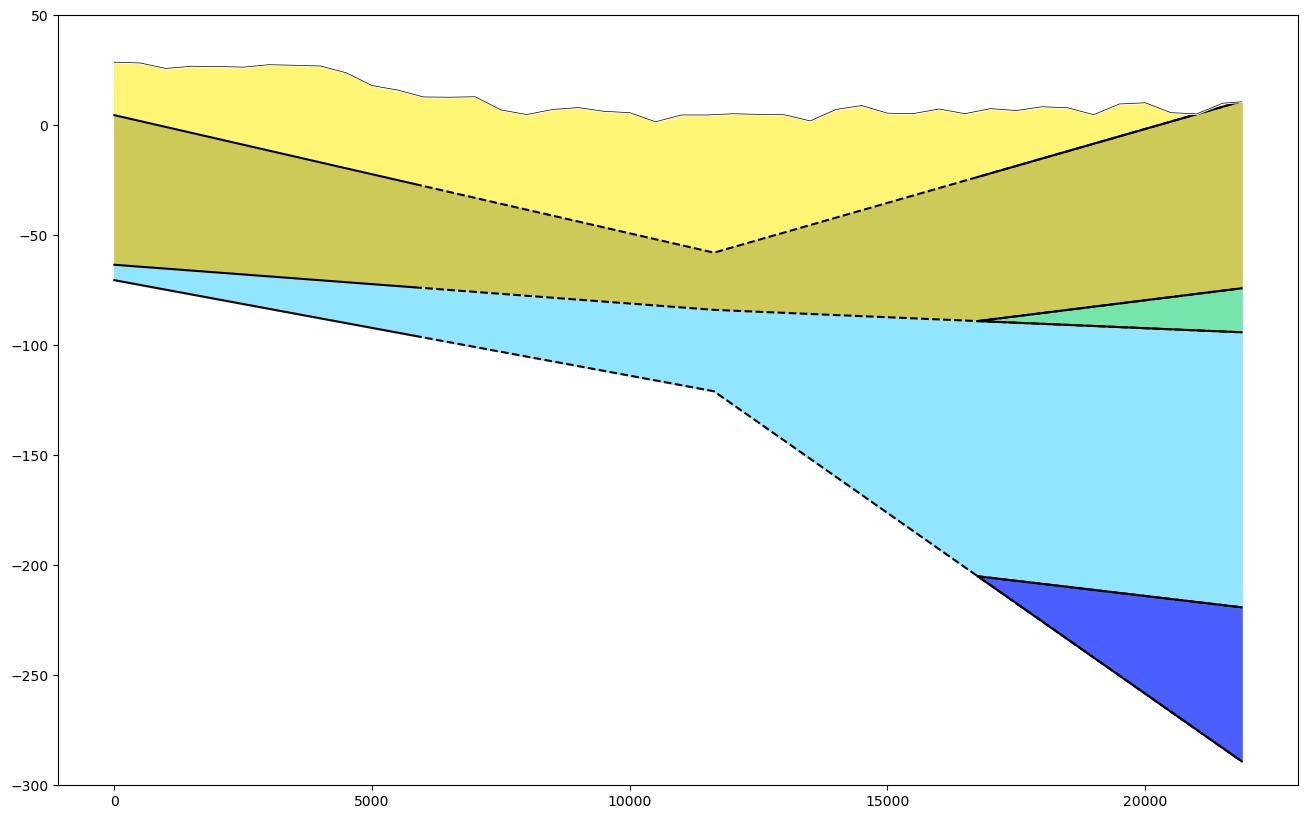

In [12]:
fig, ax = plt.subplots(figsize=(16, 10))

#Plots the surface lithology with the elevation
ax.fill_between(elev_array[1], elev_array[0], color='#FFF676', zorder = 2)
ax.fill_between(distance, elevations, og_formation_array[0], color='#FFF676', zorder = 2)
#Plots a white cover above elevation to cut off anuy formations that exceed the elevation 
ax.fill_between(elev_array[1], elev_array[0], 30, color='w', zorder=15)


color_list = ['#CECA58', '#75E5AB', '#91E5FF', '#4A5FFF']

plot_formations(ax, formation_polygons, color_list) #distance array should be included in the function

core_or_cut = [1,0,0,0,1]
dashed_solid_plot(ax, distance_test , core_or_cut, formation_test)

ax.plot(elev_array[1], elev_array[0], color='k', linewidth=0.5, zorder=16)
#Plots a white bottom layer that covers any artifacts
ax.fill_between(distance, btm, -300, color='w', )
ax.set_ylim(bottom=-300, top=50)
plt.show()